In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pylab as plt
import hockey.hockey_env as h_env

import DDPG
import torch

## Helper Functions

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)    

In [3]:
def run(env, agent, n_episodes=100, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            state, reward, done, _trunc, _info = env.step(action)
            observations.append(state)
            actions.append(action)
            ep_reward += reward
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
    print(f'Mean reward: {np.mean(rewards)}')
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

# DDPG

In [14]:
env_name = "Hockey"

alg="pure"
eps=0.3
ts=32
lr=0.0005
s=1
m=2000.0
update=20.0
with open(f"./results/DDPG_{alg}_{env_name}-m{m}-eps{eps}-t{ts}-l{lr}-s{s}-u{update}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

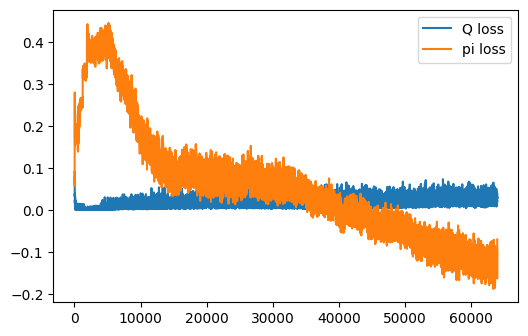

In [15]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(losses[:,0],10),label=f"Q loss")
plt.plot(running_mean(losses[:,1],10),label=f"pi loss")
plt.legend()

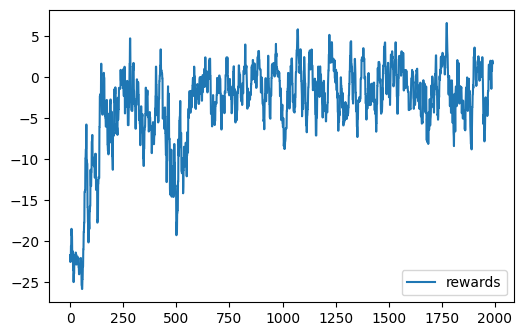

In [16]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

### Exploration Noise dependency

In [4]:
rewards = {}
lr = 0.0001
eps=[0.1,0.3,0.5]
ts=32
seed=1
env_name="pure_Hockey"
update=100.0

for e in eps:
    with open(f"./results/DDPG_{env_name}-m2000.0-eps{e}-t{ts}-l{lr}-s{seed}-u{update}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[e] = data["rewards"]

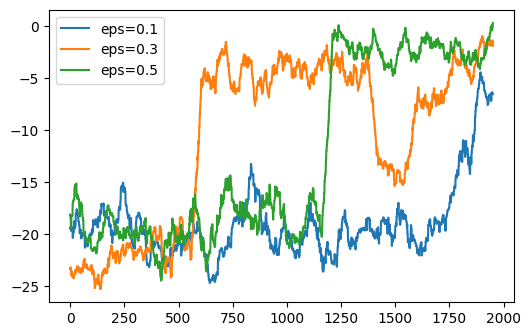

In [5]:
fig=plt.figure(figsize=(6,3.8))
for eps,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"eps={eps}")
plt.legend()

### Update interval dependency

In [7]:
rewards = {}
lr = 0.0001
eps=0.3
ts=32
env_name="pure"
seed=1
update=[10.0,20.0,50.0,100.0]  # we do a hack here by giving every run a different seed, as we do not export the update interval into the filename

for u in update:
    with open(f"./results/DDPG_{env_name}_Hockey-m2000.0-eps{eps}-t{ts}-l{lr}-s{seed}-u{u}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[data["update_every"]] = data["rewards"]

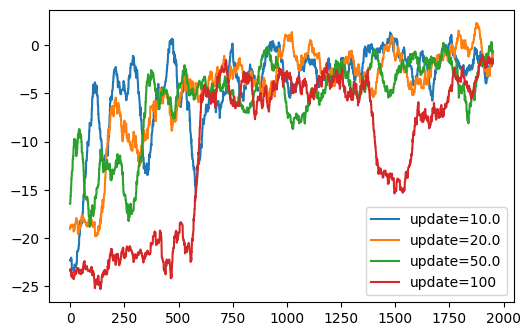

In [8]:
fig=plt.figure(figsize=(6,3.8))
for update,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"update={update}")
plt.legend()

### Learning rate dependency

Here done for update_every 20 episodes

In [12]:
rewards = {}
lrs = [0.0005, 0.0001, 0.00005]
eps=0.3
ts=32
seed=1
update=20.0

for lr in lrs:
    with open(f"./results/DDPG_{env_name}_Hockey-m2000.0-eps{eps}-t{ts}-l{lr}-s{seed}-u{update}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[data["lr"]] = data["rewards"]

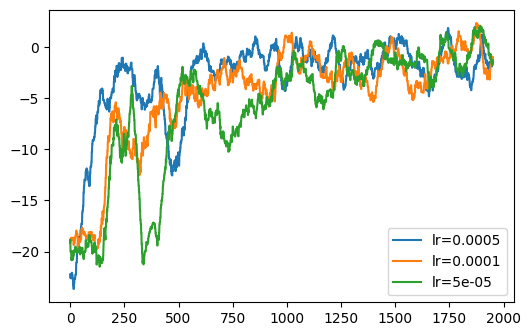

In [13]:
fig=plt.figure(figsize=(6,3.8))
for lr,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"lr={lr}")
plt.legend()

### 1.04 algorithm modifications

In [46]:
rewards = {}
lr = 0.0001
eps=0.1
ts=32
seed=1

paths = [[f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-sNone-stat.pkl", "DDPG"],
    [f"./results/pink/DDPG_{env_name}-m2000-eps{eps}-t{ts}-l{lr}-s{seed}-stat.pkl", "pink"],
    [f"./results/pinkRND/DDPG_{env_name}-m2000-eps{eps}-t{ts}-l{lr}-s{seed}-stat.pkl", "pink_RND"]]

for path in paths:
    with open(path[0], 'rb') as f:
        data = pickle.load(f)
        rewards[path[1]] = data["rewards"]

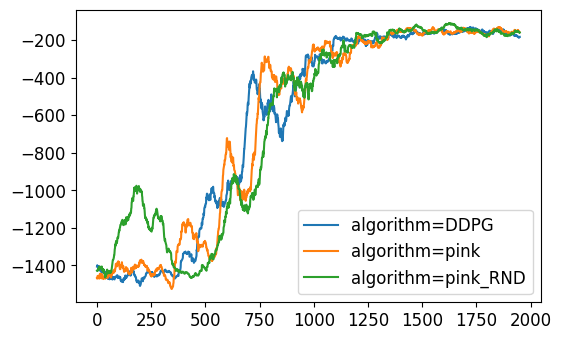

In [47]:
fig=plt.figure(figsize=(6,3.8))
for alg,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"algorithm={alg}")
plt.legend()

## value function

In [6]:
def plot_Q_function(q_function, observations, actions, plot_dim1=0, plot_dim2=2,
                    label_dim1="cos(angle)", label_dim2="angular velocity"):
    plt.rcParams.update({'font.size': 12})
    values =q_function.predict(np.hstack([observations,actions]))
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot()
    surf = ax.scatter (observations[:,plot_dim1], observations[:,plot_dim2],  c = values, cmap=cm.coolwarm)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)

    return fig

In [7]:
env = h_env.HockeyEnv()
#env = gym.make(env_name)

In [8]:
env_name = "Hockey"
alg="pinkNoiseRND"
eps=0.1
ts=32
lr=0.0001
s=None
episodes=2000
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-sNone.pth"

In [9]:
agent  = DDPG.DDPGAgent(env.observation_space, env.action_space)
agent.restore_state(torch.load(checkpoint))

C:\Users\pi030\AppData\Local\Temp\ipykernel_6280\3813471394.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.restore_state(torch.load(checkpoint))


In [ ]:
observations, actions, rewards = run(env,agent,100, noise=0.2)

Mean reward: 0.24807021904376583
[-0.22561509 -0.90207748  0.5504743   1.39302376  0.10157615 -1.15263859
 -0.58357144  0.09443342]


In [14]:
print(actions.shape)
print(actions[0])
print(observations.shape)
print(observations[0])

(17791, 8)
[-0.22561509 -0.90207748  0.5504743   1.39302376  0.10157615 -1.15263859
 -0.58357144  0.09443342]
(17791, 18)
[-3.00843406 -0.03080559  0.02279362 -0.42011079 -1.6797303   1.1396811
  2.99625254  0.04019833 -0.02416409 -0.18914178  1.86206889 -1.20820439
  1.80302191 -0.61646438  0.          0.          0.          0.        ]


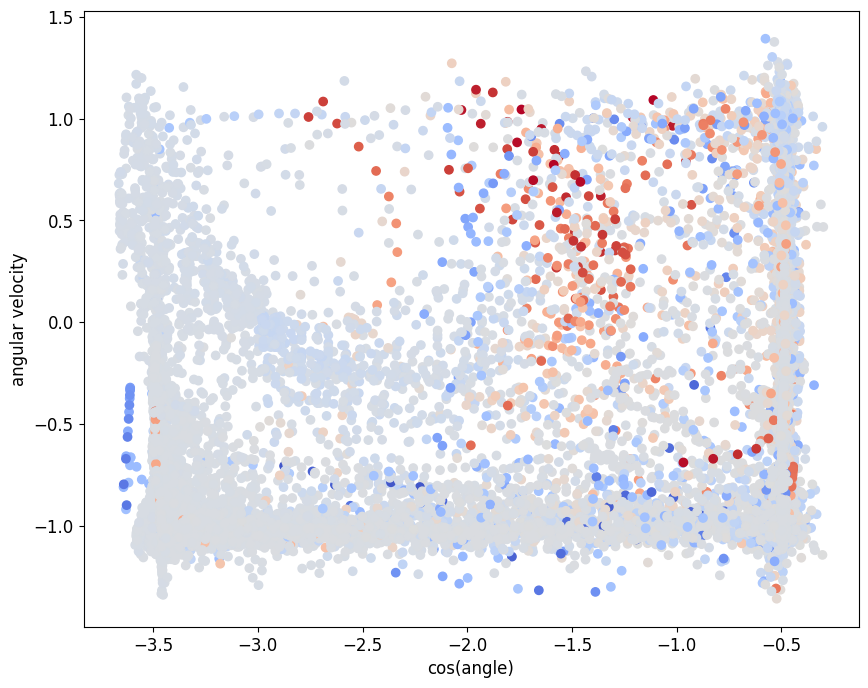

In [11]:
_ = plot_Q_function(agent.Q,observations,actions)

## HalfCheetah

In [17]:
env_name = "HalfCheetah-v4"

eps=0.1
ts=32
lr=0.0001
seed=1

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

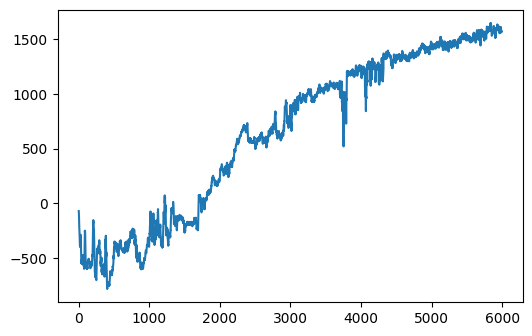

In [18]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10))

In [19]:
rewards = {}
lr = 0.0001
eps=[0.1,0.3,0.5]
ts=32
seed=1

for e in eps:
    with open(f"./results/DDPG_{env_name}-eps{e}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[e] = data["rewards"]

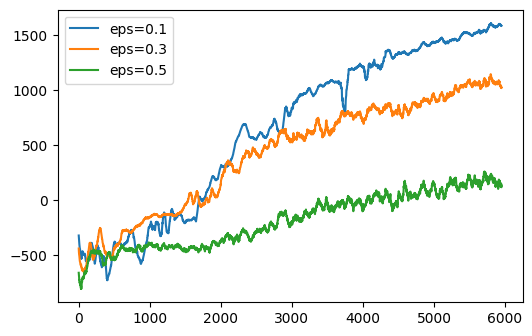

In [20]:
fig=plt.figure(figsize=(6,3.8))
for eps,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"eps={eps}")
plt.legend()

In [22]:
fig.savefig(f"DDPG_{env_name}_effect_noise.pdf")

In [23]:
env = gym.make(env_name, render_mode="human")

In [52]:
episodes=6000
eps=0.1
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

In [53]:
agent  = DDPG.DDPGAgent(env.observation_space, env.action_space)
agent.restore_state(torch.load(checkpoint))

In [54]:
observations, actions, rewards = run(env,agent,2, noise=0)

Mean reward: 465.85439331359237


In [ ]:
env.close()

## Lunar Lander
The DDPG is not able to solve the Lunar Lander (at least with our implementation and the parameters we tried)

In [56]:
env_name = "LunarLander-v2"

eps=0.1
ts=32
lr=0.0001
s=1

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

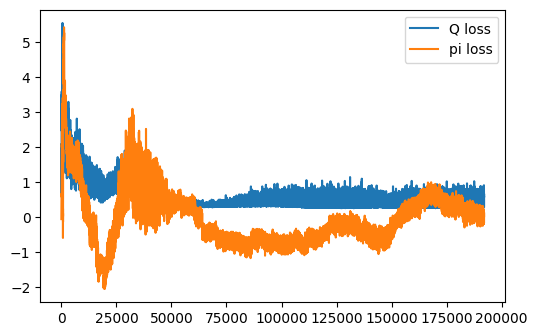

In [57]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(losses[:,0],10),label=f"Q loss")
plt.plot(running_mean(losses[:,1],10),label=f"pi loss")
plt.legend()

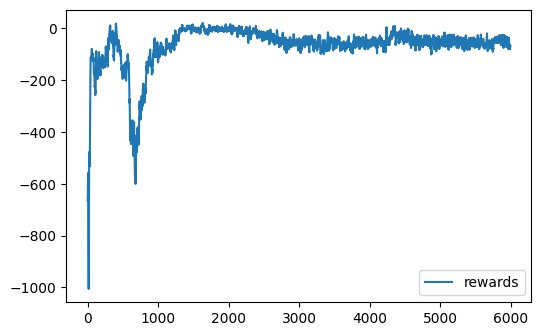

In [58]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

In [59]:
rewards = {}
lr = 0.0001
eps=[0.1,0.3,0.5]
ts=32
seed=1

for e in eps:
    with open(f"./results/DDPG_{env_name}-eps{e}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[e] = data["rewards"]

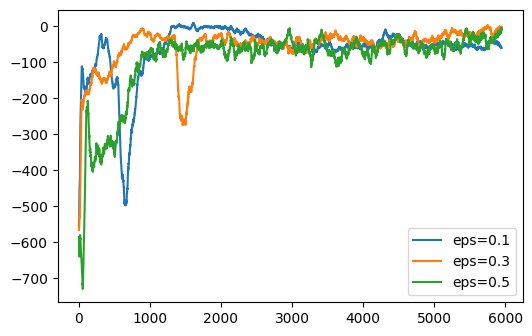

In [60]:
fig=plt.figure(figsize=(6,3.8))
for eps,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"eps={eps}")
plt.legend()

In [71]:
env = gym.make(env_name, render_mode="human", continuous=True)

In [72]:
episodes=6000
eps=0.1
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

In [73]:
agent  = DDPG.DDPGAgent(env.observation_space, env.action_space)
agent.restore_state(torch.load(checkpoint))

In [74]:
observations, actions, rewards = run(env,agent,2, noise=0)

Mean reward: -123.70174114226327


In [99]:
env.close()